# Simple Example

In [23]:
import sys

sys.path.append('/home/rcgalbo/wayy-research/wrtrade/')

In [24]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import wrtrade as wrt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
market_data = pd.Series([150.0, 160.0, 170.0])
signals = pd.Series([1, -1, 1])

# args - initial capital: float, market_data: pd.Series, signals: pd.Series
p = wrt.Portfolio(10000, market_data, signals) 
p.calculate_portfolio_returns()

In [39]:
p.current_capital

np.float64(10606.246218164355)

<Axes: >

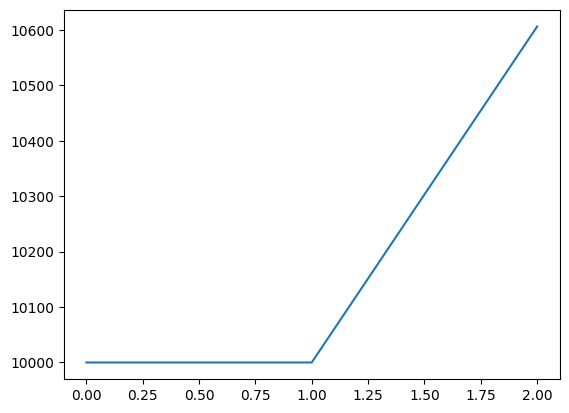

In [40]:
p.notional.plot()

<Axes: >

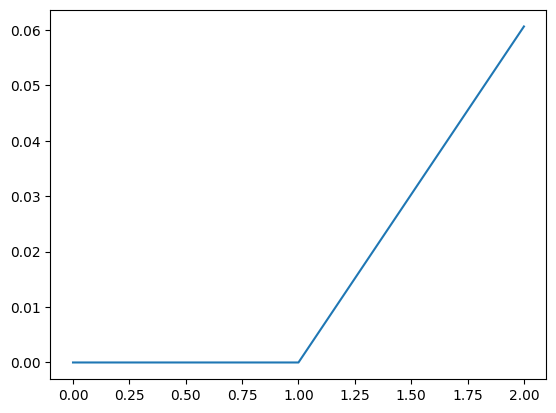

In [ ]:
p.cumulative.plot()

In [41]:
p.get_results()

{'initial_capital': 10000,
 'final_capital': np.float64(10606.246218164355),
 'total_return': np.float64(0.0606246218164355),
 'trades':    dt  price  direction
 0   0  150.0          1
 1   1  160.0         -1
 2   2  170.0          1}

## Real Example: BBCCI Strategy (BB & CCI bounce)

- Get data from alpaca
- Generate a trading signal
- Run a backtest
- Display Results

In [72]:
from alpaca.data import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime


crypto_client = CryptoHistoricalDataClient()

request_params = CryptoBarsRequest(
                        symbol_or_symbols="BTC/USD",
                        timeframe=TimeFrame.Minute,
                        start=datetime(2024, 6, 2),
                        end=datetime(2024, 7, 1)
                 )

bars = crypto_client.get_crypto_bars(request_params)

# convert to dataframe
df = bars.df

In [73]:
# cleanup
df.reset_index(inplace=True)
df.index = pd.to_datetime(df['timestamp'])
df.drop(columns=['timestamp','symbol', 'trade_count', 'vwap'], inplace=True)
df.head()

,open,high,low,close,volume
timestamp,,,,,
2024-06-02 00:06:00+00:00,67735.8775,67735.8775,67728.9950,67728.9950,0.0
2024-06-02 00:07:00+00:00,67708.9200,67708.9200,67708.9200,67708.9200,0.0
2024-06-02 00:08:00+00:00,67719.3335,67720.4800,67712.7935,67712.7935,0.0
2024-06-02 00:09:00+00:00,67726.1510,67726.8900,67710.6050,67715.3830,0.0
2024-06-02 00:10:00+00:00,67718.0300,67725.7000,67705.3215,67720.4960,0.0


In [74]:
market_data = df['close']

In [75]:
# BB
df['SMA'] = df['close'].rolling(window=200).mean()
df['SD'] = df['close'].rolling(window=200).std()
df['BBU'] = df.SMA + (df.SD * 2)
df['BBL'] = df.SMA + (df.SD * 2)

# CCI
df['typical_price'] = (df['high'] + df['low'] + df['close']) / 3
df['TPMA'] = df.rolling(window=200)['typical_price'].mean()
df['mean_devation'] = (df.typical_price - df.TPMA).abs().mean()
df['CCI'] = (df.typical_price - df.TPMA) / (0.015 * df.mean_devation)

df.dropna(inplace=True)

<Axes: >

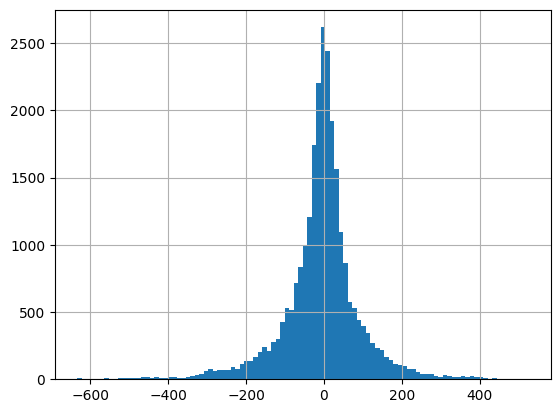

In [76]:
df.CCI.hist(bins=100)

In [124]:
# make signals
from pandas import Series, DataFrame
from wrtrade.strategy import Strategy

class BBCCI(Strategy):
    
    def generate_signals(self, market_data: DataFrame) -> Series:
        '''Returns a series of values in {1, 0, -1} for buy, hold, sell'''

        # generate entries
        signals = ((market_data.CCI < 200) & (market_data.close < market_data.BBL)).astype(int)

        return signals

strat = BBCCI()
signals = strat.generate_signals(df)

In [125]:
signals.unique()

array([1, 0])

In [126]:
from wrtrade.portfolio import Portfolio

p = Portfolio(market_data, signals)
p.calculate_portfolio_returns()
p.get_results()

{'cumulative_return': np.float64(-0.539952295494043),
 'trades':                              dt       price  direction
 0     2024-06-02 08:42:00+00:00  67786.2450          1
 1     2024-06-02 08:43:00+00:00  67760.8000          1
 2     2024-06-02 08:44:00+00:00  67777.1445          1
 3     2024-06-02 08:45:00+00:00  67773.2900          1
 4     2024-06-02 08:48:00+00:00  67745.8540          1
 ...                         ...         ...        ...
 24457 2024-06-30 23:52:00+00:00  62741.6800          1
 24458 2024-06-30 23:53:00+00:00  62769.1410          1
 24459 2024-06-30 23:54:00+00:00  62741.4430          1
 24460 2024-06-30 23:56:00+00:00  62733.0415          1
 24461 2024-06-30 23:59:00+00:00  62669.7615          1
 
 [24462 rows x 3 columns]}

<Axes: xlabel='timestamp'>

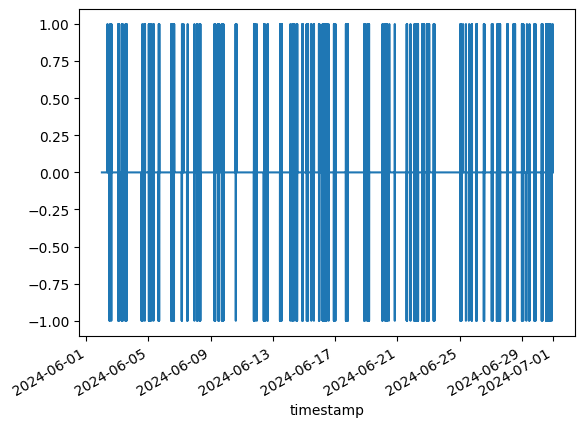

In [130]:
p.trades.ts.plot()

<Axes: xlabel='timestamp'>

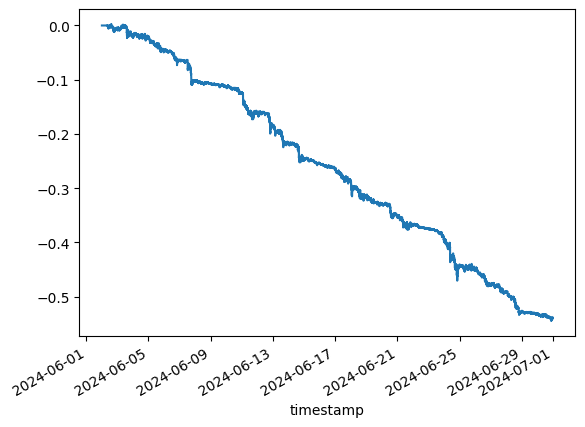

In [131]:
p.cumulative_returns.plot()

<Axes: xlabel='timestamp'>

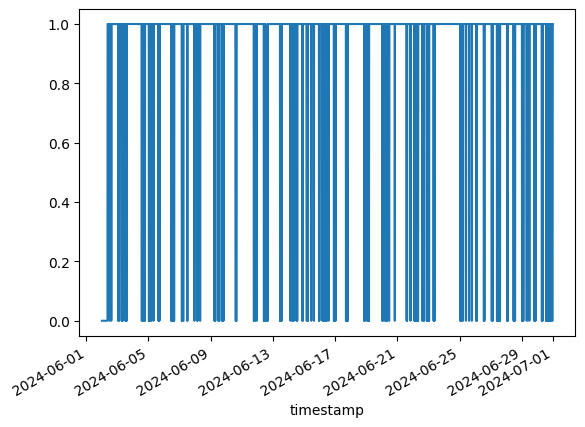

In [129]:
p.position.plot()

<Axes: xlabel='timestamp'>

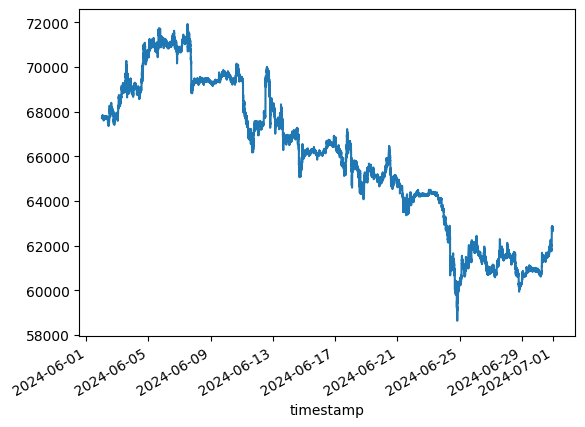

In [132]:
p.market_data.plot()